<a href="https://colab.research.google.com/github/saivigneesh456/Predic-_Cons_Sen/blob/main/Predicting_Consumer_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# required libraries
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import spacy
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load dataset 
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/senstiment/training_data.csv')
df.head()

,IDLink,Title,Headline,Source,Topic,PublishDate,Facebook,GooglePlus,LinkedIn,SentimentTitle,SentimentHeadline
0,Tr3CMgRv1N,Obama Lays Wreath at Arlington National Cemetery,Obama Lays Wreath at Arlington National Cemete...,USA TODAY,obama,02-04-2002 00:00,-1,-1,-1,0.000000,-0.053300
1,Wc81vGp8qZ,A Look at the Health of the Chinese Economy,"Tim Haywood, investment director business-unit...",Bloomberg,economy,20-09-2008 00:00,-1,-1,-1,0.208333,-0.156386
2,zNGH03CrZH,Nouriel Roubini: Global Economy Not Back to 2008,"Nouriel Roubini, NYU professor and chairman at...",Bloomberg,economy,28-01-2012 00:00,-1,-1,-1,-0.425210,0.139754
3,3sM1H0W8ts,Finland GDP Expands In Q4,Finland's economy expanded marginally in the t...,RTT News,economy,01-03-2015 00:06,-1,-1,-1,0.000000,0.026064
4,wUbnxgvqaZ,"Tourism, govt spending buoys Thai economy in J...",Tourism and public spending continued to boost...,The Nation - Thailand&#39;s English news,economy,01-03-2015 00:11,-1,-1,-1,0.000000,0.141084


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40508 entries, 0 to 40507
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   IDLink             40508 non-null  object 
 1   Title              40508 non-null  object 
 2   Headline           40508 non-null  object 
 3   Source             40390 non-null  object 
 4   Topic              40508 non-null  object 
 5   PublishDate        40508 non-null  object 
 6   Facebook           40508 non-null  int64  
 7   GooglePlus         40508 non-null  int64  
 8   LinkedIn           40508 non-null  int64  
 9   SentimentTitle     40508 non-null  float64
 10  SentimentHeadline  40508 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 3.4+ MB


In [ ]:
data = df[["Source","Topic"]]
data.head()

,Source,Topic
0,USA TODAY,obama
1,Bloomberg,economy
2,Bloomberg,economy
3,RTT News,economy
4,The Nation - Thailand&#39;s English news,economy


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40508 entries, 0 to 40507
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Source  40390 non-null  object
 1   Topic   40508 non-null  object
dtypes: object(2)
memory usage: 633.1+ KB


In [ ]:
# drop missing values
data.dropna(inplace=True)
data.isnull().sum()

Source    0
Topic     0
dtype: int64

In [ ]:
# explore some of the reviews
import random

n_samples = 5

for _ in range(n_samples):
    i = random.choice(range(data.shape[0]))
    print(f"Source Text:\n{data['Source'][i]} \n\nRATE:\n{data['Topic'][i]}")
    print('\n', 90*"-", '\n')

Source Text:
MSNBC 

RATE:
obama

 ------------------------------------------------------------------------------------------ 

Source Text:
Economic Times 

RATE:
obama

 ------------------------------------------------------------------------------------------ 

Source Text:
The Express Tribune 

RATE:
economy

 ------------------------------------------------------------------------------------------ 

Source Text:
PYMNTS.com 

RATE:
economy

 ------------------------------------------------------------------------------------------ 

Source Text:
Breitbart News 

RATE:
obama

 ------------------------------------------------------------------------------------------ 



In [ ]:
# descriptive statistics
data.describe()

,Source,Topic
count,40390,40390
unique,4092,4
top,Bloomberg,economy
freq,725,14965


In [ ]:
# distribution of rating
data['Source'].value_counts().sort_index(ascending=False)

                      1
yourcentralvalley.com     1
www.worldbulletin.net    85
wwlp.com                  1
wtkr.com                  2
                         ..
12NewsNow.Com             2
12 News Phoenix           3
/FILM                     1
+972 Magazine            13
                         34
Name: Source, Length: 4092, dtype: int64

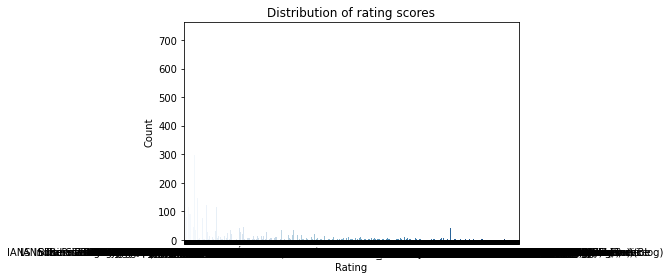

In [ ]:
# distribution of rating
sns.countplot(data['Source'], palette='Blues')

plt.title('Distribution of rating scores')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
# load the other data
data2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/senstiment/training_data.csv")
data2 = data2[['Facebook', 'LinkedIn']]
# use only data of rating lower than or equal to 3
data2 = data2[data2[""] <= 3].reset_index(drop=True) # reset index after filtering rows

data3 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/senstiment/test_data.csv")
data3 = data3[['Facebook', 'LinkedIn']]
# use only data of rating lower than or equal to 3
data3 = data3[data3["Facebook"] <= 3].reset_index(drop=True) # reset index after filtering rows

In [ ]:
# distribution of rating
data2['LinkedIn'].value_counts().sort_index(ascending=False)

 3     1106
 2     1597
 1     3238
 0    21624
-1     2767
Name: LinkedIn, dtype: int64

In [ ]:
# distribution of rating
data3['Facebook'].value_counts().sort_index(ascending=False)

 3     674
 2     833
 1    1185
 0    3067
-1    1145
Name: Facebook, dtype: int64

In [ ]:
# concatenation
data = pd.concat([data, data2, data3])

# assert data.shape[0] == data.shape[0] + data2.shape[0] + data3.shape[0]
data.head()

,Source,Topic,Facebook,LinkedIn
0,USA TODAY,obama,NaN,NaN
1,Bloomberg,economy,NaN,NaN
2,Bloomberg,economy,NaN,NaN
3,RTT News,economy,NaN,NaN
4,The Nation - Thailand&#39;s English news,economy,NaN,NaN


In [ ]:
# distribution of rating
data['Facebook'].value_counts().sort_index(ascending=False)

 30489.0        1
 24594.0        1
 19771.0        1
 19136.0        1
 14952.0        1
            ...  
 3.0         2020
 2.0         2742
 1.0         3904
 0.0        10788
-1.0         3957
Name: Facebook, Length: 1245, dtype: int64

In [ ]:
# map ratings 1, 2, 3 to 0 (NEGATIVE) and 4, 5 to 1 (POSITIVE) 
sentiment_score = {1: 0,
                   2: 0,
                   3: 0,
                   4: 1,
                   5: 1}

sentiment = {0: 'NEGATIVE',
             1: 'POSITIVE'}


# mapping
data['sentiment_score'] = data['Facebook'].map(sentiment_score)
data['sentiment'] = data['LinkedIn'].map(sentiment)

data.head()

,Source,Topic,Facebook,LinkedIn,sentiment_score,sentiment
0,USA TODAY,obama,NaN,NaN,NaN,NaN
1,Bloomberg,economy,NaN,NaN,NaN,NaN
2,Bloomberg,economy,NaN,NaN,NaN,NaN
3,RTT News,economy,NaN,NaN,NaN,NaN
4,The Nation - Thailand&#39;s English news,economy,NaN,NaN,NaN,NaN


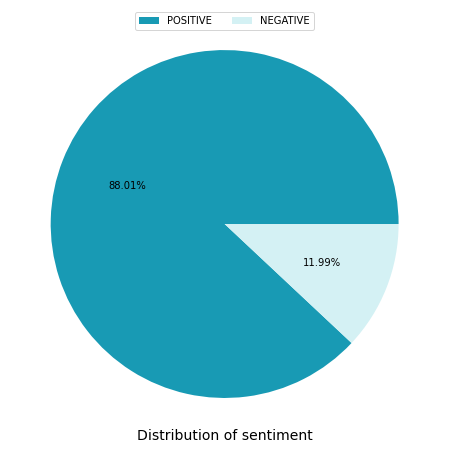

In [ ]:
# distribution of sentiment
plt.figure(figsize = (8, 8))

labels = ['POSITIVE', 'NEGATIVE']
colors = ['#189AB4', '#D4F1F4']
plt.pie(data['sentiment'].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Distribution of sentiment', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.show()

In [ ]:
def clean_text(text:str):
    """ Return cleaned text:
            - lowercase
            - remove whitespaces
            - remove HTML tags
            - replace digit with spaces
            - replace punctuations with spaces
            - remove extra spaces and tabs
        ------
        input: text (str)    
        output: cleaned text (str)
    """
    text = str(text)
    
    text = text.lower()
    text = text.strip()
    
    text = re.sub(' \d+', ' ', text)
    text = re.compile('<.*?>').sub('', text)
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    
    text = text.strip()
    
    return text

In [ ]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
clean_text(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'this is a message to be cleaned it may involve some things like adjacent spaces and tabs'

In [ ]:
def remove_stopwords(text:str):
    """ Remove stopwords from text:
        ------
        input: text (str)    
        output: cleaned text (str)
    """
    text = str(text)
    filtered_sentence = []

    # Stop word lists can be adjusted for your problem
    stop_words = ["a", "an", "the", "this", "that", "is", "it", "to", "and"]

    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(w)
    text = " ".join(filtered_sentence)
    
    return text

In [ ]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
remove_stopwords(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'message be cleaned may involve some things like adjacent spaces tabs'

In [ ]:
def stemm_text(text:str):
    """ Stemm text:
    ------
    input: text (str)    
    output: Stemmed text (str)
    """
    text = str(text)
    # Initialize the stemmer
    snow = SnowballStemmer('english')

    stemmed_sentence = []
    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        # Stem the word/token
        stemmed_sentence.append(snow.stem(w))
    text = " ".join(stemmed_sentence)
    
    return text

In [ ]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
text = remove_stopwords(text)
stemm_text(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'messag be clean may involv some thing like adjac space tab'

In [ ]:
# This is a helper function to map NTLK position tags
# Full list is available here: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
def lemmatize(text:str):
    """ lemmatize text:
    ------
    input: text (str)    
    output: lemmatized text (str)
    """
    text = str(text)
    
    # Initialize the lemmatizer
    wl = WordNetLemmatizer()

    lemmatized_sentence = []

    # Tokenize the sentence
    words = word_tokenize(text)
    # Get position tags
    word_pos_tags = nltk.pos_tag(words)
    # Map the position tag and lemmatize the word/token
    for idx, tag in enumerate(word_pos_tags):
        lemmatized_sentence.append(wl.lemmatize(tag[0], get_wordnet_pos(tag[1])))

    lemmatized_text = " ".join(lemmatized_sentence)
    
    return lemmatized_text

In [ ]:
# test
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .  "
print(text, '\n')
text = clean_text(text)
text = remove_stopwords(text)
# text = stemm_text(text)
lemmatize(text)

   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  26 adjacent spaces and tabs     .   



'message be clean may involve some thing like adjacent space tabs'

In [ ]:
# clean text
data['text'] = data['Topic'].apply(clean_text)
# remove stopwords
data['text'] = data['text'].apply(remove_stopwords)
# lemmatize
data['text'] = data['text'].apply(lemmatize)

In [ ]:
# check some processed reviews
import random

i = random.choice(range(len(data)))

print(f"Original review: \n{data['Facebook'].iloc[i]}\n")
print(f"Processed review: \n{data['text'].iloc[i]}")  

Original review: 
nan

Processed review: 
nan


In [ ]:
# export cleaned data to csv
data.to_csv('/content/drive/MyDrive/Colab Notebooks/senstiment/sample.csv', index=False)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/senstiment/sample.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77626 entries, 0 to 77625
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Source           40390 non-null  object 
 1   Topic            40390 non-null  object 
 2   Facebook         37236 non-null  float64
 3   LinkedIn         37236 non-null  float64
 4   sentiment_score  10509 non-null  float64
 5   sentiment        30029 non-null  object 
 6   text             40390 non-null  object 
dtypes: float64(3), object(4)
memory usage: 4.1+ MB


In [ ]:
data[data['text'].isnull()]

,Source,Topic,Facebook,LinkedIn,sentiment_score,sentiment,text
40390,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN
40391,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN
40392,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN
40393,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN
40394,NaN,NaN,-1.0,-1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
77621,NaN,NaN,0.0,0.0,NaN,NEGATIVE,NaN
77622,NaN,NaN,0.0,0.0,NaN,NEGATIVE,NaN
77623,NaN,NaN,0.0,0.0,NaN,NEGATIVE,NaN
77624,NaN,NaN,0.0,0.0,NaN,NEGATIVE,NaN


In [ ]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Source           0 non-null      object 
 1   Topic            0 non-null      object 
 2   Facebook         0 non-null      float64
 3   LinkedIn         0 non-null      float64
 4   sentiment_score  0 non-null      float64
 5   sentiment        0 non-null      object 
 6   text             0 non-null      object 
dtypes: float64(3), object(4)
memory usage: 0.0+ bytes


In [ ]:
train_data['Facebook'].value_counts()

NameError: ignored